### Libraries:

In [1]:
# Core Libraries:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from io import BytesIO
from zipfile import ZipFile
import requests

# Modelling Libraries:

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Models:

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Model, load_model
from keras.layers import Input, Dense

### Loading the Data:

In [2]:
# Loading Credit Card Fraud Dataset:

url_fraud = 'https://github.com/manugaco/ML_User_Cases/blob/master/Datasets/Fraud_detection/fraud.zip?raw=true'
zip_fraud = ZipFile(BytesIO(requests.get(url_fraud).content), 'r')
df_fraud = pd.read_csv(zip_fraud.open(zip_fraud.namelist()[0]), low_memory=False)

### Data Preview:

In [3]:
df_fraud.shape

(284807, 31)

In [4]:
df_fraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df_fraud['Class'].value_counts().reset_index().apply(lambda x: x/x.sum())

,index,Class
0,0.0,0.998273
1,1.0,0.001727


In [6]:
df_fraud = df_fraud.drop([ 'Time'], axis = 1)
df_fraud['Amount'] = StandardScaler().fit_transform(df_fraud['Amount'].values.reshape(-1, 1))

### Modelling:

#### Train-test split:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df_fraud.drop('Class',1) , df_fraud['Class'], test_size=0.2, random_state=0)

In [8]:
y_test.value_counts().reset_index().apply(lambda x: x/x.sum())

,index,Class
0,0.0,0.998227
1,1.0,0.001773


In [9]:
y_train.value_counts().reset_index().apply(lambda x: x/x.sum())

,index,Class
0,0.0,0.998284
1,1.0,0.001716


In [10]:
X_train_nofraud = X_train[y_train==0]
X_train_fraud = X_train[y_train==1]

In [11]:
input_layer = Input(shape=(X_train.shape[1], ))
encoded = Dense(8, activation='relu')(input_layer)
decoded = Dense(X_train.shape[1], activation='relu')(encoded)
autoencoder = Model(input_layer,decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
autoencoder.fit(X_train_nofraud, X_train_nofraud, epochs = 10, batch_size=128, validation_data=(X_train_nofraud, X_train_nofraud))

Epoch 1/10
1777/1777 [==============================] - 8s 4ms/step - loss: 0.8678 - val_loss: 0.7886
Epoch 2/10
1777/1777 [==============================] - 7s 4ms/step - loss: 0.7702 - val_loss: 0.7575
Epoch 3/10
1777/1777 [==============================] - 6s 3ms/step - loss: 0.7545 - val_loss: 0.7519
Epoch 4/10
1777/1777 [==============================] - 6s 4ms/step - loss: 0.7501 - val_loss: 0.7473
Epoch 5/10
1777/1777 [==============================] - 6s 4ms/step - loss: 0.7447 - val_loss: 0.7428
Epoch 6/10
1777/1777 [==============================] - 7s 4ms/step - loss: 0.7422 - val_loss: 0.7420
Epoch 7/10
1777/1777 [==============================] - 6s 4ms/step - loss: 0.7416 - val_loss: 0.7410
Epoch 8/10
1777/1777 [==============================] - 7s 4ms/step - loss: 0.7410 - val_loss: 0.7407
Epoch 9/10
1777/1777 [==============================] - 8s 4ms/step - loss: 0.7405 - val_loss: 0.7401
Epoch 10/10
1777/1777 [==============================] - 7s 4ms/step - loss: 0.739

In [13]:
predictions = autoencoder.predict(X_train)
mse = np.mean(np.power(X_train - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_train})
error_df.groupby('true_class').describe()

reconstruction_error                                            \
                          count       mean        std       min       25%   
true_class                                                                  
0                      227454.0   0.739905   2.941118  0.044585  0.248583   
1                         391.0  27.083909  37.885873  0.107868  4.537698   

                                             
                 50%        75%         max  
true_class                                   
0           0.407832   0.681270  317.736349  
1           9.822470  27.640622  265.385473

In [14]:
test_predictions = autoencoder.predict(X_test)
mse = np.mean((X_test - test_predictions)**2, axis=1)
y_pred = [(lambda er: 1 if er>=11.5  else 0)(er) for er in mse]

In [15]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
print("ROC AUC: %.2f%%" % (round(metrics.auc(fpr, tpr)*100, 2)))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
precision = precision_score(y_test, y_pred)
print("Precision: %.2f%%" % (precision * 100.0))
recall = recall_score(y_test, y_pred)
print("Recall: %.2f%%" % (recall * 100.0))
f1 = f1_score(y_test, y_pred)
print("F1: %.2f%%" % (f1 * 100.0))

ROC AUC: 75.04%
Accuracy: 99.50%
Precision: 17.96%
Recall: 50.50%
F1: 26.49%


## Visualization:

### Original Data: PCA on input and make out target classes.

In [16]:
x = StandardScaler().fit_transform(X_train.reset_index(drop=True))

pca = PCA(n_components=2)
pcs = pca.fit_transform(x)
pcdf = pd.DataFrame(pcs, columns = ['pc1', 'pc2'])
pcdf = pd.concat([y_train.reset_index(drop=True), pcdf], axis=1)
pcdf['Class'] = np.where(pcdf['Class'] == 0, 'no_fraud', 'fraud')

In [17]:
pcdf = pcdf[(pcdf['pc1'] < 50) & (pcdf['pc2'] < 50)]

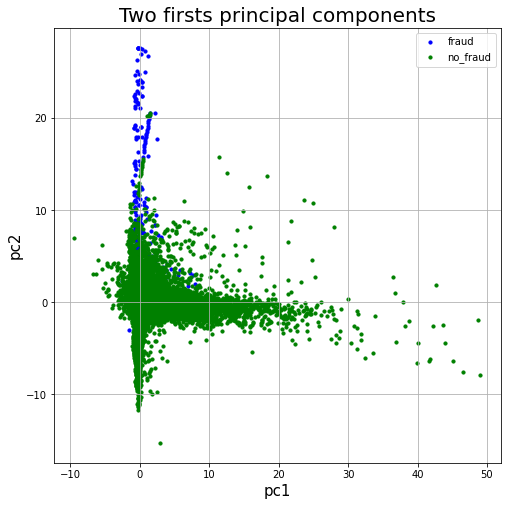

In [18]:

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('pc1', fontsize = 15)
ax.set_ylabel('pc2', fontsize = 15)
ax.set_title('Two firsts principal components', fontsize = 20)
targets = ['fraud', 'no_fraud']
colors = ['b', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = pcdf['Class'] == target
    ax.scatter(pcdf.loc[indicesToKeep, 'pc1']
               , pcdf.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()